## This notebook does slew simulations, check all aos components (M1M3, M2, hexapods) behavior during the slew-and-track process, and applies MTAOS corrections for each visit.

This is expected to work both for SUMMIT and NCSA

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

Patching auth into notebook.base.handlers.IPythonHandler(notebook.base.handlers.AuthenticatedHandler) -> IPythonHandler(jupyterhub.singleuser.mixins.HubAuthenticatedHandler, notebook.base.handlers.AuthenticatedHandler)


'lsst-nts-kub06'

In [33]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd
import logging

from lsst.ts.idl.enums import MTHexapod

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

<Figure size 432x288 with 0 Axes>

In [4]:
#summit = 1 #use this for summit testing
summit = 0 #use this for NCSA

In [5]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/ts_ddsconfig/config/ospl-shmem.xml
ncsa
0


In [6]:
logging.basicConfig(format="%(name)s:%(message)s", level=logging.DEBUG)

In [7]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

In [9]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

Read historical data in 0.00 sec


In [10]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

In [11]:
await mtcs.start_task

Read historical data in 0.10 sec
Read historical data in 0.12 sec
electrical DDS read queue is filling: 59 of 100 elements
elevation DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 81 of 100 elements
application DDS read queue is filling: 60 of 100 elements
cameraCableWrap DDS read queue is full (100 elements); data may be lost


[None, None, None, None, None, None, None, None, None, None]

application DDS read queue is filling: 81 of 100 elements
actuators DDS read queue is filling: 60 of 100 elements
powerSupplyData DDS read queue is full (100 elements); data may be lost
timeAndDate DDS read queue is full (100 elements); data may be lost
azimuth DDS read queue is full (100 elements); data may be lost


In [12]:
mtcs.components_attr

actuators DDS read queue is filling: 83 of 100 elements
pidData DDS read queue is full (100 elements); data may be lost
mountStatus DDS read queue is full (100 elements); data may be lost
inclinometerData DDS read queue is full (100 elements); data may be lost
mountPosition DDS read queue is full (100 elements); data may be lost
imsData DDS read queue is full (100 elements); data may be lost
currentTargetStatus DDS read queue is full (100 elements); data may be lost
hardpointMonitorData DDS read queue is full (100 elements); data may be lost
hardpointActuatorData DDS read queue is full (100 elements); data may be lost
gyroData DDS read queue is full (100 elements); data may be lost
forceActuatorData DDS read queue is full (100 elements); data may be lost
accelerometerData DDS read queue is full (100 elements); data may be lost


['mtmount',
 'mtptg',
 'mtaos',
 'mtm1m3',
 'mtm2',
 'mthexapod_1',
 'mthexapod_2',
 'mtrotator',
 'mtdome',
 'mtdometrajectory']

In [13]:
ptg = mtcs.rem.mtptg
mount = mtcs.rem.mtmount
rot = mtcs.rem.mtrotator
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
aos = mtcs.rem.mtaos

### Get Ptg ready

In [13]:
await ptg.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await ptg.cmd_start.set_start()

In [ ]:
await salobj.set_summary_state(ptg, salobj.State.ENABLED)

### Get Mount ready

In [14]:
await mount.evt_heartbeat.next(flush=True, timeout=5)

In [15]:
sim_evt = await mount.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  1 2021-07-20 22:18:58.604257280


In [38]:
a = await mount.evt_softwareVersions.aget(timeout=5)
print('software version? ', a.cscVersion, pd.to_datetime(a.private_sndStamp, unit='s'))

software version?  0.18.1 2021-07-20 22:18:58.619161088


In [17]:
a = await mount.evt_cameraCableWrapFollowing.aget()
print(a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

1 2021-07-20 22:23:24.012753664


In [ ]:
await salobj.set_summary_state(mount, salobj.State.OFFLINE)

In [ ]:
await mount.cmd_start.set_start()

In [50]:
await salobj.set_summary_state(mount, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
await showSlewError(ptg, mount, rot)

### Get Rotator ready

In [17]:
await checkSlewCompStates(ptg, mount, rot)

staring with: ptg state State.ENABLED 2021-07-20 22:23:20.695201024
staring with: mount state State.ENABLED 2021-07-20 22:23:24.013198336
staring with: rot state State.ENABLED 2021-07-20 22:23:24.021773312


In [ ]:
await salobj.set_summary_state(rot, salobj.State.OFFLINE)

In [ ]:
await salobj.set_summary_state(rot, salobj.State.ENABLED)

In [19]:
sim_evt = await rot.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  1 2021-07-20 22:18:59.801024


In [18]:
a = await mount.tel_elevation.next(flush=True, timeout=5)
print("mount elevation Angle = ", a.actualPosition)
a = await mount.tel_azimuth.next(flush=True, timeout=5)
print("mount azimuth angle = ", a.actualPosition)
a = await mount.tel_cameraCableWrap.next(flush=True, timeout=5)
print("CCW angle = ", a.actualPosition, " Needs to be within 2.2 deg of rotator angle ")
b = await rot.tel_rotation.next(flush=True, timeout=5)
print("rot angle = ", b.actualPosition, "   diff = ", (b.actualPosition - a.actualPosition))

mount elevation Angle =  81.0
mount azimuth angle =  0.0
CCW angle =  0.0  Needs to be within 2.2 deg of rotator angle 
rot angle =  -9.574540925694275e-08    diff =  -9.574540925694275e-08


In [ ]:
a = await rot.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

In [ ]:
#a = await mount.evt_cameraCableWrapState.aget(timeout=5.)
#print(a.state)
a = await mount.evt_cameraCableWrapFollowing.aget(timeout=5.)
print(a.enabled)

In [ ]:
await mount.cmd_enableCameraCableWrapFollowing.set_start()

In [ ]:
await rot.cmd_clearError.set_start()

In [ ]:
await rot.cmd_start.set_start()

In [ ]:
await salobj.set_summary_state(mount, salobj.State.DISABLED)
await salobj.set_summary_state(mount, salobj.State.ENABLED)
a = await mount.evt_cameraCableWrapFollowing.aget()
print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

In [ ]:
await rot.cmd_move.set_start(0)

### Get MTAOS Ready

In [14]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await salobj.set_summary_state(aos, salobj.State.ENABLED) #, settingsToApply='default') #leave this out!!
#two levels of defaults: csc defaults, config repo; right now csc defaults, they will move to config repo; 
#but to load defaults from config repo, we do not need to supply settingsToApply

In [19]:
a = await aos.evt_softwareVersions.aget(timeout=5)
print('software version? ', a.cscVersion, pd.to_datetime(a.private_sndStamp, unit='s'))

#this is MTAOS version. How do I get OFC version? and WEP version?

software version?  v0.7.1 2021-07-21 18:12:42.352967680


In [20]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

### Check that all components are ready

In [21]:
await checkAOSCompStates(m1m3, m2, camhex, m2hex)

starting with: M1M3 state State.ENABLED 2021-07-21 20:59:11.074752768
          detailed state DetailedState.ACTIVE 2021-07-21 20:59:11.074911232
staring with: m2 state State.ENABLED 2021-07-20 22:23:20.768551936
staring with: cam hex state State.ENABLED 2021-07-20 22:23:21.119513344
          cam hex state EnabledSubstate.STATIONARY 2021-07-21 21:01:55.194302208
staring with: M2 hex state State.ENABLED 2021-07-20 22:23:21.118926336
          hex state EnabledSubstate.STATIONARY 2021-07-21 21:03:26.738207488


In [22]:
await checkSlewCompStates(ptg, mount, rot)

staring with: ptg state State.ENABLED 2021-07-20 22:23:20.695201024
staring with: mount state State.ENABLED 2021-07-20 22:23:24.013198336
staring with: rot state State.ENABLED 2021-07-20 22:23:24.021773312


In [23]:
await checkAOSSummaryStates(aos, m1m3,m2,camhex,m2hex)

starting with: MTAOS state State.ENABLED 2021-07-21 18:13:36.469178880
starting with: M1M3 state State.ENABLED 2021-07-21 20:59:11.074752768
          detailed state DetailedState.ACTIVE 2021-07-21 20:59:11.074911232
staring with: m2 state State.ENABLED 2021-07-20 22:23:20.768551936
staring with: cam hex state State.ENABLED 2021-07-20 22:23:21.119513344
          cam hex state EnabledSubstate.STATIONARY 2021-07-21 21:01:55.194302208
staring with: M2 hex state State.ENABLED 2021-07-20 22:23:21.118926336
          hex state EnabledSubstate.STATIONARY 2021-07-21 21:03:26.738207488


### Get M1M3 ready (Mount telemetry mode)

In [51]:
#Move to zenith (so that we can start m1m3 with LUT in mount telemetry mode)
await mount.cmd_moveToTarget.set_start(azimuth=0, elevation=90)

In [26]:
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

In [ ]:
print('Re-enabling M1M3')
#await salobj.set_summary_state(m1m3, salobj.State.STANDBY) 
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

In [24]:
await readyM1M3(m1m3)

m1m3 inclinometer Angle =  81.00399780273438
M1M3 is raised
m1m3 z position =  0.0
Magnitude of the m1m3 force balance system 218.229736328125


In [ ]:
await m1m3.cmd_abortRaiseM1M3.set_start(timeout=15.)

In [ ]:
a = await m1m3.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

In [53]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-07-20 17:58:16.603898880
m1m3 state DetailedState.PARKED 2021-07-20 18:00:43.783618048


### Get M2 ready

In [27]:
await m2.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await checkAOSCompStates(m1m3,m2,camhex,m2hex)

In [ ]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE) 

In [ ]:
await salobj.set_summary_state(m2, salobj.State.STANDBY) 

In [ ]:
await salobj.set_summary_state(m2, salobj.State.DISABLED) 

In [ ]:
#remember to reset interlock
await salobj.set_summary_state(m2, salobj.State.ENABLED) 

In [ ]:
a = await m2.evt_errorCode.aget()
print(a.errorCode, a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

In [ ]:
await m2.cmd_enterControl.set_start(timeout=.5)

In [ ]:
await m2.cmd_exitControl.set_start(timeout=.5)

In [ ]:
await m2.cmd_enable.set_start(timeout=5.)

In [ ]:
await m2.cmd_disable.set_start(timeout=5.)

In [ ]:
await m2.cmd_clearErrors.set_start(timeout=15.)

In [25]:
await readyM2(m2)

m2 inclinometer angle =  9.09050047535716
Inclinometer Source InclinationTelemetrySource.ONBOARD  ,event time =  2021-07-20 22:23:20.758424576
Status of the M2 force balance system True
clear any M2 activeopticForces (or any other hunman-applied forces)


### Get camHex ready

In [35]:
target_evt = await mount.evt_target.aget(timeout=5.)
print("Mount target elevation = ", target_evt.elevation, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))
print("Mount target azimuth   = ", target_evt.azimuth, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))
target_evt = await rot.evt_target.aget(timeout=5.)
print("Rotator target position = ", target_evt.position, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))

Mount target elevation =  81.0   @   2021-07-21 21:01:13.122840320
Mount target azimuth   =  0.0   @   2021-07-21 21:01:13.122840320
Rotator target position =  0.0   @   2021-07-21 21:01:33.929862400


In [34]:
#if any of the above doesn't work
#await mount.cmd_moveToTarget.set_start(azimuth=0, elevation=81)
await rot.cmd_move.set_start(position=0)

In [ ]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [37]:
sim_evt = await camhex.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  1 2021-07-20 22:18:51.878999296


In [ ]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

In [ ]:
await camhex.cmd_clearError.set_start()

In [ ]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply='default')

In [26]:
await readyHexaForAOS(camhex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-20 22:23:20.863748096
pivot at (0, 0, 500000) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled? True 2021-07-21 21:00:15.051228160
hexa in position? False 2021-07-21 23:22:42.781048576
hexa in position? True 2021-07-21 23:22:42.983064832
Current Hexapod position
     -0.88    -446.10     385.80  -0.012203  -0.000000   0.000000
hexa in position? False 2021-07-21 23:22:43.185392896
hexa in position? True 2021-07-21 23:22:43.286624
Current Hexapod position
     -0.86    -446.10     285.84  -0.012203   0.000000  -0.000000
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-21 23:22:43.087976448
Compensated position
     -0.88    -446.14     285.82      -0.012203   0.000000   0.000000    2021-07-21 23:22:43.088177920
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
m

In [38]:
await printHexaUncompensatedAndCompensated(m2hex)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-20 17:45:47.753095680
Compensated position
     -2.15    -491.08     307.31      -0.005733   0.000000   0.000000    2021-07-20 17:45:47.753287424


In [39]:
await printHexaUncompensatedAndCompensated(camhex)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-20 17:45:47.755436544
Compensated position
     -0.91    -560.92     294.00      -0.015284   0.000000   0.000000    2021-07-20 17:45:47.755623936


In [ ]:
import lsst.ts.idl.enums.MTHexapod as enum_hex
a = await camhex.evt_controllerState.aget()
print(a.applicationStatus, pd.to_datetime(a.private_sndStamp, unit='s'))
enum_hex.ApplicationStatus(a.applicationStatus[0])

### Get m2Hex ready

In [ ]:
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply='default') #works if it is offline

In [ ]:
sim_evt = await m2hex.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

In [27]:
await readyHexaForAOS(m2hex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-20 22:23:20.861909760
pivot at (0, 0, 500000) microns 
maxXY =  10500.0 microns, maxZ=  8900.0  microns
maxUV =  0.175 deg, maxW=  0.05  deg
compsensation mode enabled? True 2021-07-21 21:03:25.426776064
hexa in position? False 2021-07-21 23:22:51.000083968
hexa in position? True 2021-07-21 23:22:51.100889600
Current Hexapod position
     -2.45    -389.59     403.47  -0.004588  -0.000000  -0.000000
hexa in position? False 2021-07-21 23:22:51.404521216
hexa in position? True 2021-07-21 23:22:51.505738240
Current Hexapod position
     -2.42    -389.60     303.51  -0.004588  -0.000000  -0.000000
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-21 23:22:51.303590656
Compensated position
     -2.46    -389.57     303.48      -0.004588   0.000000   0.000000    2021-07-21 23:22:51.303869440
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not

In [ ]:
end = Time(datetime.now(), scale='tai')
start = end - timedelta(seconds=1000)
df = await client.select_time_series('lsst.sal.ESS.temperature8Ch', '*', start, end, csc_index)
if len(df)>0:
    fig, ax = plt.subplots(1,1, figsize=(15,4))
    for i in range(8):
        plt.plot(getattr(df, 'temperatureC%02d'%i))
    plt.grid()
else:
    print('No temperature data on the camera hexapod in the past 1000s.')

### Do a few slews

#### Do 4 slews, then stop tracking

In [28]:
#comment and uncomment the below depending on which components are expected to be on
#by default, MTCS checks on every component (during the slew).
mtcs.check.mtaos = False
mtcs.check.mtm1m3 = True
mtcs.check.mtm2 = True
mtcs.check.mthexapod_1 = True
mtcs.check.mthexapod_2 = True
mtcs.check.mtdome = False
mtcs.check.mtdometrajectory = False

In [29]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

CCW folowing?  1 2021-07-20 22:23:24.012753664
moving from elevation 84.9 deg to 82.3 deg 2021-07-21 23:56:08.475689
This will run for 121 seconds
rot in position? True 2021-07-21 23:59:34.561626112
start a slew, elevation diff =  0.09383522823048907 2021-07-21 23:58:57.564600
CCW folowing?  1 2021-07-20 22:23:24.012753664
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubE

Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


CCW folowing?  1 2021-07-20 22:23:24.012753664
moving from elevation 82.6 deg to 84.7 deg 2021-07-22 00:00:06.952213
This will run for 102 seconds
rot in position? True 2021-07-22 00:03:14.632802816
start a slew, elevation diff =  0.06698202977510448 2021-07-22 00:02:37.634694
CCW folowing?  1 2021-07-20 22:23:24.012753664
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubE

Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


CCW folowing?  1 2021-07-20 22:23:24.012753664
moving from elevation 84.9 deg to 82.3 deg 2021-07-22 00:03:49.523307
This will run for 121 seconds
rot in position? True 2021-07-22 00:07:15.461697024
start a slew, elevation diff =  0.09614313114859385 2021-07-22 00:06:38.464339
CCW folowing?  1 2021-07-20 22:23:24.012753664
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubE

Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


CCW folowing?  1 2021-07-20 22:23:24.012753664
moving from elevation 82.6 deg to 84.7 deg 2021-07-22 00:07:48.587092
This will run for 102 seconds
rot in position? True 2021-07-22 00:10:54.829081088
start a slew, elevation diff =  0.0992212717401344 2021-07-22 00:10:17.836907
CCW folowing?  1 2021-07-20 22:23:24.012753664
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEv

Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


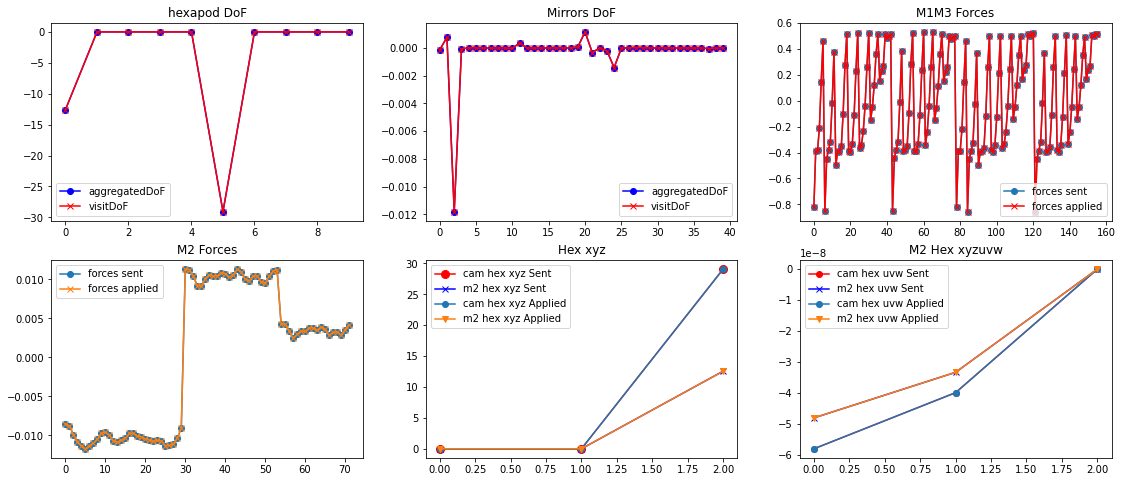

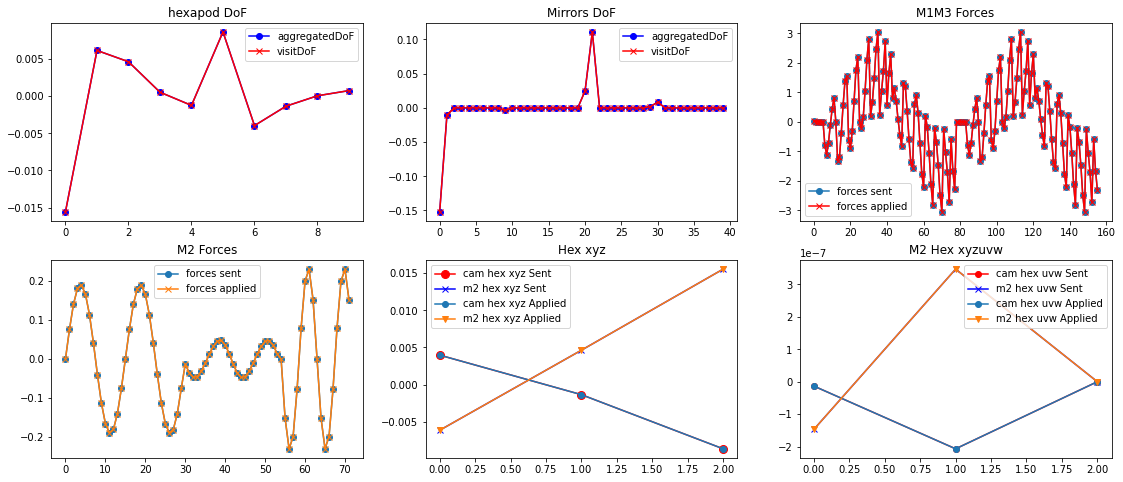

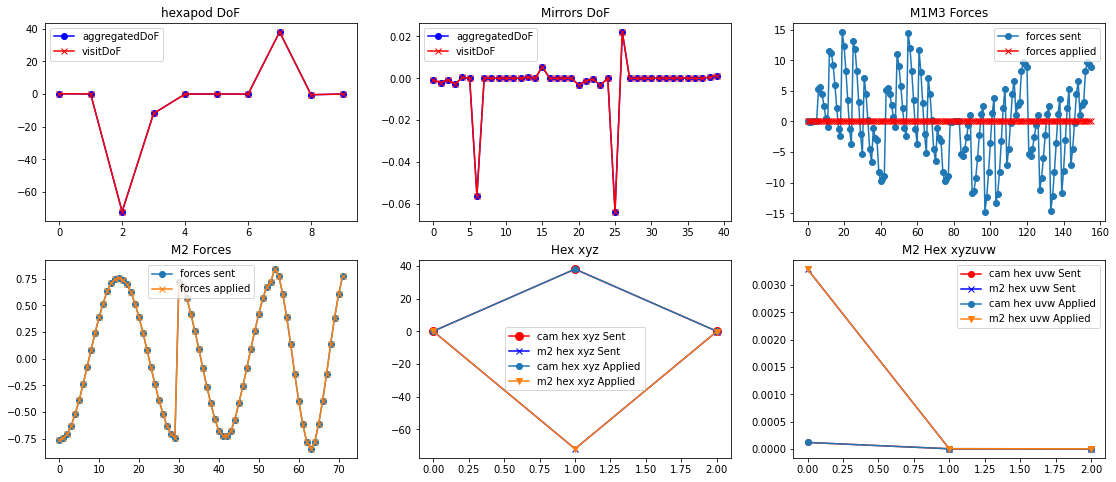

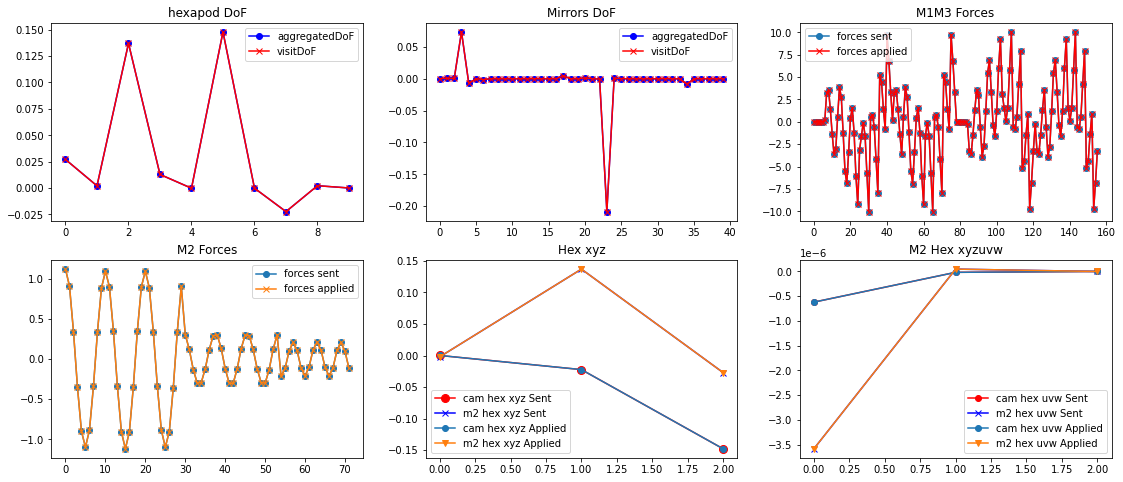

In [37]:
dec = -34.
for j in range(2):
    for i in range(2):
        
        a = await mount.evt_cameraCableWrapFollowing.aget()
        print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))
        if not a.enabled:
            break
        time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
        ra = time_and_date.lst + 0.5 - 3.5/15.0 * i
        
        aa = await mount.tel_elevation.next(flush=True, timeout=5.)
        current_el = aa.actualPosition
        
        obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 0.) #with 0s delay
        azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
        target_el = azel.alt.value
        
        while abs(target_el - current_el)>0.3:
            print('moving from elevation %.1f deg to %.1f deg'%(current_el, target_el), Time.now())
            await moveMountConstantV(mount, current_el, target_el)
        
            aa = await mount.tel_elevation.next(flush=True, timeout=5.)
            current_el = aa.actualPosition
        
            time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
            ra = time_and_date.lst + 0.5 - 3.5/15.0 * i
    
            obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 0.) #with 0s delay
            azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
            target_el = azel.alt.value
        
        await moveRotTo0(rot, 10.0)
        
        print('start a slew, elevation diff = ', abs(target_el - current_el), Time.now())
        a = await mount.evt_cameraCableWrapFollowing.aget()
        print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))
        if not a.enabled:
            break
            
        await aos.cmd_resetCorrection.set_start()
        await aos.cmd_issueCorrection.set_start() 
        k = j*2+i
        zernikes = np.zeros(19)
        if k==0:
            zernikes[4-4] = 1 #add 1um of z4
        elif k==1:
            zernikes[5-4] = 1 #add 1um of z5
        elif k==2:
            zernikes[7-4] = 1 #add 1um of z7
        elif k==3:
            zernikes[9-4] = 1 #add 1um of z9
        await aos.cmd_addAberration.set_start(wf = zernikes)
        await aos.cmd_issueCorrection.set_start() 
        await asyncio.sleep(2.0)

        ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

        rotAngle = 10.0
        print('zero-indexed: ', k, 'rot = ', rotAngle)
        #b = await mount.tel_cameraCableWrap.next(flush=True, timeout=5) #CCW doesn't follow rotator!!!
        # await mtcs.slew_icrs(ra=ra, dec=dec, rot=b.actualPosition, rot_type=RotType.PhysicalSky)
        await mtcs.slew_icrs(ra=ra, dec=dec, rot=rotAngle, rot_type=RotType.PhysicalSky)
        #await mtcs.slew_icrs(ra=ra, dec=dec, rot=0.0, rot_type=RotType.Physical)
        await asyncio.sleep(39.)
        await mtcs.stop_tracking()

In [40]:
await mtcs.stop_tracking()

#### Plot the above process

In [ ]:
#end = Time(datetime.now(), scale='tai')
end = Time('2021-07-13T19:18:00', scale='tai')
start = end - timedelta(seconds=1000)

In [ ]:
dfm2

In [ ]:
dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedElevationForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.application', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot((dfm.actualPosition-dfm.actualPosition[0])*100, '--', label='mount elevation x 100 (deg)')
plt.plot(dfm1m3.yForces0-dfm1m3.yForces0[0], label='M1M3 elevation y-force 101 (N)')
plt.plot((dfm2.lutGravity0-dfm2.lutGravity0[0])*10, label='M2 elevation force B1 x 10 (N)')
plt.plot(dfh1.position1-dfh1.position1[0], label='Camera hexapod y (um)')
plt.plot(dfh2.position1-dfh2.position1[0], label='M2 hexapod y (um)')
plt.grid()
plt.legend()
plt.title('Changes in telemetry')

#### Check if the telescope is in tracking mode. If yes, need to stop stacking.

The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await mtcs.stop_tracking()

### put mount elevation back to 90 deg, so that we can lower M1M3

In [ ]:
aa = await mount.tel_elevation.next(flush=True, timeout=5.)
current_el = aa.actualPosition

In [ ]:
await moveMountConstantV(mount,current_el, 90)

In [ ]:
await lowerM1M3(m1m3)

#### Close up. Put all simulators to standby

In [40]:
await mtcs.stop_tracking()

In [41]:
await salobj.set_summary_state(ptg, salobj.State.STANDBY)

[<State.FAULT: 3>, <State.STANDBY: 5>]

In [ ]:
await salobj.set_summary_state(rot, salobj.State.OFFLINE)

In [44]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [45]:
await salobj.set_summary_state(m2hex, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [47]:
await salobj.set_summary_state(m2, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [48]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE)

[<State.STANDBY: 5>, <State.OFFLINE: 4>]

In [ ]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-07-20 17:58:16.603898880


In [54]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

[<State.ENABLED: 2>,
 <State.DISABLED: 1>,
 <State.STANDBY: 5>,
 <State.OFFLINE: 4>]

In [55]:
await salobj.set_summary_state(mount, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [ ]:
await rot.cmd_clearError.set_start()

In [ ]:
await m2.cmd_exitControl.set_start()

In [ ]:
await checkAOSCompStates(m1m3,m2,camhex, m2hex)

In [ ]:
await checkSlewCompStates(ptg,mount, rot)